In [1]:
!pip install --upgrade flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import jax.numpy as jnp
import numpy as np
from jax import random, vmap, grad, jit

import flax.linen as nn
import optax

from typing import Any, Callable, Sequence, Optional, Union, Dict

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [8]:
class MLP(nn.Module):
    num_layers: int=2
    hidden_dim: int=64
    output_dim: int=1
    activation: Callable=nn.gelu

    @nn.compact
    def __call__(self, x):
        for _ in range(self.num_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = self.activation(x)
        x = nn.Dense(self.output_dim)(x)
        return x

In [9]:
class MLPregression:
    # Initialize the class
    def __init__(self, arch, batch, rng_key=random.PRNGKey(0)):
        
        # Initialization and evaluation functions
        inputs, _ = batch
        self.model = arch
        self.params = self.model.init(rng_key, inputs)
        print(self.model.tabulate(rng_key, inputs))

        # Optimizer
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.adam(learning_rate=lr)
        self.opt_state = self.optimizer.init(self.params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.model.apply(params, inputs)
        loss = jnp.mean((targets - outputs)**2)
        return loss 

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, params, opt_state, batch):
        grads = grad(self.loss)(params, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state


    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.params, self.opt_state = self.step(self.params, self.opt_state, batch)
            # Logger
            if it % 100 == 0:
                loss = self.loss(self.params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

In [10]:
!wget https://github.com/maziarraissi/backprop/raw/master/training_data.csv
!wget https://github.com/maziarraissi/backprop/raw/master/test_data.csv

--2023-03-28 18:02:10--  https://github.com/maziarraissi/backprop/raw/master/training_data.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/backprop/master/training_data.csv [following]
--2023-03-28 18:02:11--  https://raw.githubusercontent.com/maziarraissi/backprop/master/training_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5100 (5.0K) [text/plain]
Saving to: ‘training_data.csv.1’

training_data.csv.1 100%[===================>]   4.98K  --.-KB/s    in 0s      

2023-03-28 18:02:11 (71.3 MB/s) - ‘training_data.csv.1’ saved [5100/5100]

--2023-03-28 18:02:11--  https:

In [13]:
training_data = np.loadtxt("training_data.csv")
X = jnp.array(training_data[:,0:1], dtype=jnp.float32)
Y = jnp.array(training_data[:,1:2], dtype=jnp.float32)

# Normalization constants
mu_X, sigma_X = X.mean(0), X.std(0)
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
norm_const = (mu_X, sigma_X), (mu_Y, sigma_Y)

rng_key = random.PRNGKey(0)

In [14]:
from torch.utils import data

class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 norm_const=((0.0, 1.0), (0.0, 1.0)), 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.norm_const = norm_const
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        (mu_X, sigma_X), (mu_Y, sigma_Y) = self.norm_const
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[idx,:]
        targets = Y[idx,:]
        inputs = (inputs - mu_X)/sigma_X
        targets = (targets - mu_Y)/sigma_Y
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [16]:
dataset = DataGenerator(X, Y, norm_const, batch_size=32)
data = iter(dataset)
batch = next(data)

In [17]:
arch = MLP(num_layers=2,
           hidden_dim=128,
           output_dim=1)
model = MLPregression(arch, batch)


                                  MLP Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs          ┃ outputs         ┃ params                ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[32,1]   │ float32[32,1]   │ Dense_0:              │
│         │        │                 │                 │   bias: float32[128]  │
│         │        │                 │                 │   kernel:             │
│         │        │                 │                 │ float32[1,128]        │
│         │        │                 │                 │ Dense_1:              │
│         │        │                 │                 │   bias: float32[128]  │
│         │        │                 │                 │   kernel:             │
│         │        │                 │                 │ float32[128,128]      │
│         │        │       

In [18]:
model.train(dataset, nIter=10000)

100%|██████████| 10000/10000 [00:16<00:00, 614.09it/s, loss=0.00049988576]


In [19]:
# Validate predictions
test_data = np.loadtxt("test_data.csv")
X_test = jnp.array(test_data[:,0:1], dtype=np.float32)
Y_test = jnp.array(test_data[:,1:2], dtype=np.float32)

# Normalize test inputs
X_star = (X_test - mu_X)/sigma_X

# Predict
Y_pred = model.model.apply(model.params, X_star)
# De-normalize predicted outputs
Y_pred = Y_pred*sigma_Y + mu_Y

Error 2.210598e-02


Text(0, 0.5, 'Loss')

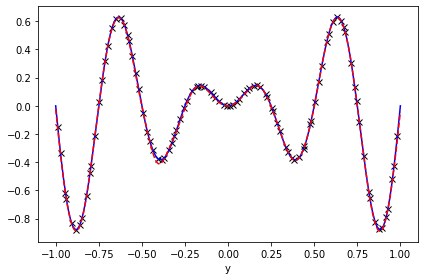

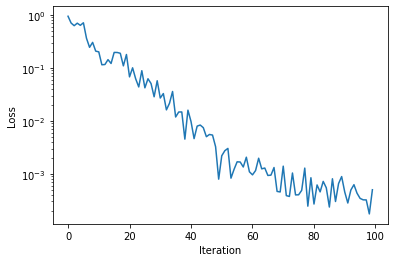

In [20]:
error = np.linalg.norm(Y_pred - Y_test)/np.linalg.norm(Y_test)
print('Error %e' %(error))

plt.figure()
plt.plot(X,Y,'kx')
plt.plot(X_test,Y_test,'b-')
plt.plot(X_test,Y_pred,'r--')
plt.xlabel('x')
plt.xlabel('y')
plt.tight_layout()

plt.figure()
plt.plot(np.array(model.loss_log))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')